In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Build Adjacency Matrices

In [3]:
genie3 = pd.read_csv('../GENIE3_net_gene_symbols_undirected.tsv', sep='\t')
grnboost2 = pd.read_csv('../GRNBoost2_net_gene_symbols_undirected.tsv', sep='\t')
pidc = pd.read_csv('../PIDC_net_gene_symbols_undirected.tsv', sep='\t')

# shared genes
genes_genie3 = set(genie3['TF']) | set(genie3['target'])
genes_grnboost2 = set(grnboost2['TF']) | set(grnboost2['target'])
genes_pidc = set(pidc['TF']) | set(pidc['target'])

shared_genes = sorted(genes_genie3 & genes_grnboost2 & genes_pidc)
print(f"Number of shared genes: {len(shared_genes)}")

gene_idx = {gene: i for i, gene in enumerate(shared_genes)}

# ADJACENCY MATRICES
def build_adjacency_matrix(df, shared_genes, gene_idx):
    n = len(shared_genes)
    adj = np.zeros((n, n))
    for _, row in df.iterrows():
        tf, tgt, score = row['TF'], row['target'], row['importance']
        if tf in gene_idx and tgt in gene_idx:
            i, j = gene_idx[tf], gene_idx[tgt]
            adj[i, j] = score
            adj[j, i] = score  # assume undirected
    return adj

adj_genie3 = build_adjacency_matrix(genie3, shared_genes, gene_idx)
adj_grnboost2 = build_adjacency_matrix(grnboost2, shared_genes, gene_idx)
adj_pidc = build_adjacency_matrix(pidc, shared_genes, gene_idx)

pd.DataFrame(adj_genie3, index=shared_genes, columns=shared_genes).to_csv('adjacency_GENIE3.csv')
pd.DataFrame(adj_grnboost2, index=shared_genes, columns=shared_genes).to_csv('adjacency_GRNBoost2.csv')
pd.DataFrame(adj_pidc, index=shared_genes, columns=shared_genes).to_csv('adjacency_PIDC.csv')


Number of shared genes: 355


## Comparison
1. Find genes shared across all three matrices,  
2. Filters the adjacency matrices to only include the common genes  
3. Flatten the upper triangle (excluding the diagonal) into a 1D list  
4. Calculate the pearson and spearman correlations between the flattened versions of the matrices  
   pearson: linear relationship between two sets of scores. DO need to normalize - Z-score normalization is better here than min-max scaling, because it centers the data and removes
effects from different variances, which fits Pearson's assumptions better
      +1 means perfectly aligned, 0 means no linear relationship
      Compares actual values (even after normalization)
   Spearman: measures the monotonic (rank) relationship. Do NOT need to normalize for this test since it is rank-based
      Copmares only the order of the numbers, not their size
   
GENIE3 vs GRNBoost2: Moderate positive similarity — the edge weights are somewhat aligned between GENIE3 and GRNBoost2, both in size (Pearson) and rank (Spearman)  
GENIE3 vs PIDC: Also moderate similarity but slightly weaker than GENIE3 vs GRNBoost2  
GRNBoost2 vs PIDC: Weak similarity, GRNBoost2 and PIDC produce much less similar edge patterns compared to the other pairs  
GENIE3 and GRNBoost2 are more similar to each other than either is to PIDC.  
PIDC appears to produce a different type of network — meaning the edges it finds important are often not the same as GENIE3 or GRNBoost2.  
GENIE3 and GRNBoost2 are both based on tree-based methods (Random Forests, Gradient Boosting), so it's not surprising they agree more.  
PIDC is information-theory based (Partial Information Decomposition), a different way of inferring edges, so it finds different relationships.

In [5]:
from scipy.stats import pearsonr, spearmanr
from itertools import combinations

genie3_adj = pd.read_csv("adjacency_GENIE3.csv", index_col=0)
grnboost2_adj = pd.read_csv("adjacency_GRNBoost2.csv", index_col=0)
pidc_adj = pd.read_csv("adjacency_PIDC.csv", index_col=0)

# find shared genes
common_genes = sorted(set(genie3_adj.index) & set(grnboost2_adj.index) & set(pidc_adj.index))
print(f"Number of common genes: {len(common_genes)}")

# subset matrices to shared genes
genie3_adj2 = genie3_adj.loc[common_genes, common_genes]
grnboost2_adj2 = grnboost2_adj.loc[common_genes, common_genes]
pidc_adj2 = pidc_adj.loc[common_genes, common_genes]

# flatten matrices
def flatten_upper(matrix):
    return matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool)).stack()

flat_genie3 = flatten_upper(genie3_adj2)
flat_grnboost2 = flatten_upper(grnboost2_adj2)
flat_pidc = flatten_upper(pidc_adj2)

# Z-score normalization
def zscore_normalize(x):
    return (x - np.mean(x)) / np.std(x)

flat_genie3_norm = zscore_normalize(flat_genie3)
flat_grnboost2_norm = zscore_normalize(flat_grnboost2)
flat_pidc_norm = zscore_normalize(flat_pidc)

# CORRELATION between matrices
def corr_info(x_norm, y_norm, x_raw, y_raw, label1, label2):
    pearson_corr = pearsonr(x_norm, y_norm)[0]  # use normalized data
    spearman_corr = spearmanr(x_raw, y_raw)[0]  # use raw data
    print(f"\n{label1} vs {label2}:")
    print(f"  Pearson correlation (normalized):  {pearson_corr:.4f}")
    print(f"  Spearman correlation:              {spearman_corr:.4f}")

corr_info(flat_genie3_norm, flat_grnboost2_norm, flat_genie3, flat_grnboost2, "GENIE3", "GRNBoost2")
corr_info(flat_genie3_norm, flat_pidc_norm, flat_genie3, flat_pidc, "GENIE3", "PIDC")
corr_info(flat_grnboost2_norm, flat_pidc_norm, flat_grnboost2, flat_pidc, "GRNBoost2", "PIDC")

Number of common genes: 355

GENIE3 vs GRNBoost2:
  Pearson correlation (normalized):  0.4393
  Spearman correlation:              0.4167

GENIE3 vs PIDC:
  Pearson correlation (normalized):  0.4001
  Spearman correlation:              0.3201

GRNBoost2 vs PIDC:
  Pearson correlation (normalized):  0.1924
  Spearman correlation:              0.2162


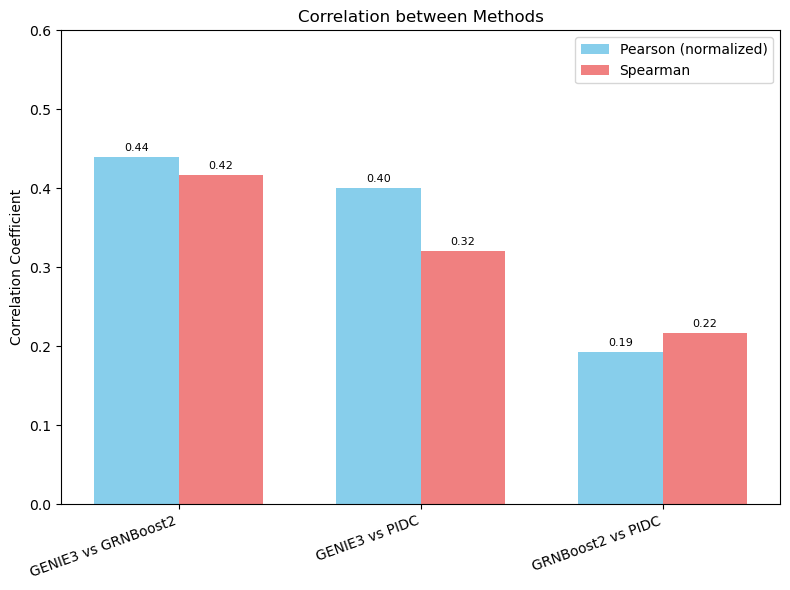

In [6]:
# Barplots for correlation values
comparisons = ["GENIE3 vs GRNBoost2", "GENIE3 vs PIDC", "GRNBoost2 vs PIDC"]
pearson = [0.4393, 0.4001, 0.1924]
spearman = [0.4167, 0.3201, 0.2162]

x = np.arange(len(comparisons))  # label locations
width = 0.35  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, pearson, width, label='Pearson (normalized)', color='skyblue')
bars2 = ax.bar(x + width/2, spearman, width, label='Spearman', color='lightcoral')

# Add labels, title, legend
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Correlation between Methods')
ax.set_xticks(x)
ax.set_xticklabels(comparisons, rotation=20, ha='right')
ax.legend()
ax.set_ylim(0, 0.6) 

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [7]:
common_genes[0:4]

['5S_rRNA', 'A2ML1', 'ACOT1', 'ADA2']

In [8]:
k = 1000 

def top_k_edges(flattened, k):
    return set(flattened.sort_values(ascending=False).head(k).index)

top_genie3 = top_k_edges(flat_genie3, k)
top_grnboost2 = top_k_edges(flat_grnboost2, k)
top_pidc = top_k_edges(flat_pidc, k)

print(f"\nTop-{k} edge overlaps:")
print(f"GENIE3 ∩ GRNBoost2: {len(top_genie3 & top_grnboost2)}")
print(f"GENIE3 ∩ PIDC: {len(top_genie3 & top_pidc)}")
print(f"GRNBoost2 ∩ PIDC: {len(top_grnboost2 & top_pidc)}")
print(f"All 3: {len(top_genie3 & top_grnboost2 & top_pidc)}")


Top-1000 edge overlaps:
GENIE3 ∩ GRNBoost2: 563
GENIE3 ∩ PIDC: 315
GRNBoost2 ∩ PIDC: 258
All 3: 225


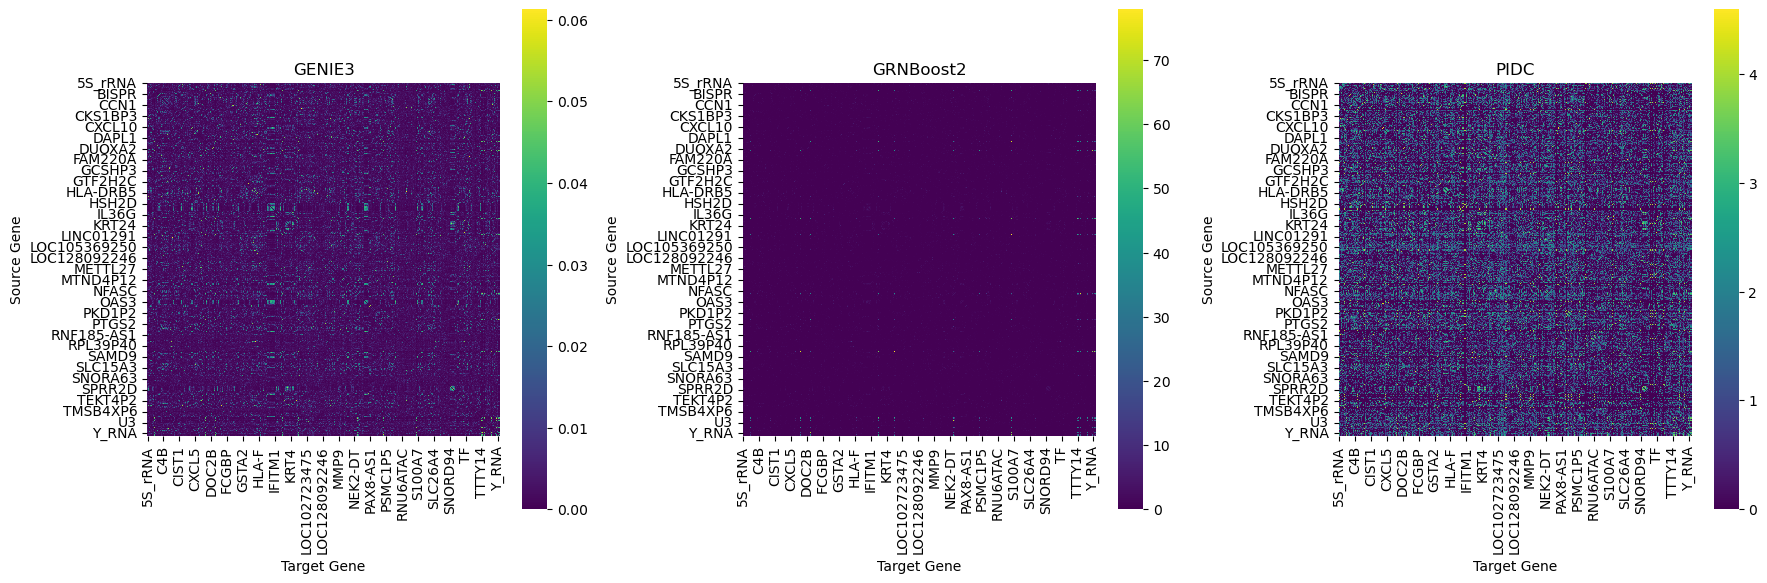

In [10]:
# heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(genie3_adj2, cmap="viridis", square=True, cbar=True, ax=axes[0])
axes[0].set_title("GENIE3")
axes[0].set_xlabel("Target Gene")
axes[0].set_ylabel("Source Gene")

sns.heatmap(grnboost2_adj2, cmap="viridis", square=True, cbar=True, ax=axes[1])
axes[1].set_title("GRNBoost2")
axes[1].set_xlabel("Target Gene")
axes[1].set_ylabel("Source Gene")

sns.heatmap(pidc_adj2, cmap="viridis", square=True, cbar=True, ax=axes[2])
axes[2].set_title("PIDC")
axes[2].set_xlabel("Target Gene")
axes[2].set_ylabel("Source Gene")

plt.tight_layout()
plt.show()